In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('../../Datasets/AMD Historical Data.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4029.199, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4040.749, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4029.289, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4030.785, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4041.379, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4028.263, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4028.096, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4028.261, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4026.678, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4028.301, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4027.093, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4027.752, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.161 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [4]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted prices for the next 30 days:')
print(y_next_30_days)

Predicted prices for the next 30 days:
[89.742469   89.84748345 89.89687776 89.97644015 90.03963953 90.11171412
 90.17897484 90.24884658 90.31730212 90.3865258  90.45533284 90.52436586
 90.59327631 90.66225325 90.73119412 90.80015456 90.86910438 90.93805996
 91.00701242 91.07596657 91.1449198  91.21387353 91.28282699 91.3517806
 91.42073413 91.4896877  91.55864124 91.6275948  91.69654836 91.76550191]


In [6]:
# 7. Đánh giá độ chính xác validate, test
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mape(y_test, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mse = mean_squared_error(y_val, y_pred_val)
valid_mae = mean_absolute_error(y_val, y_pred_val)
valid_mape = mape(y_val, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
# print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
# print("Validation MAPE:", valid_mape)

Testing RMSE: 27.41642014236196
Testing MAE: 22.383214410002875
Validation RMSE: 18.729349121737794
Validation MAE: 16.300770275974333


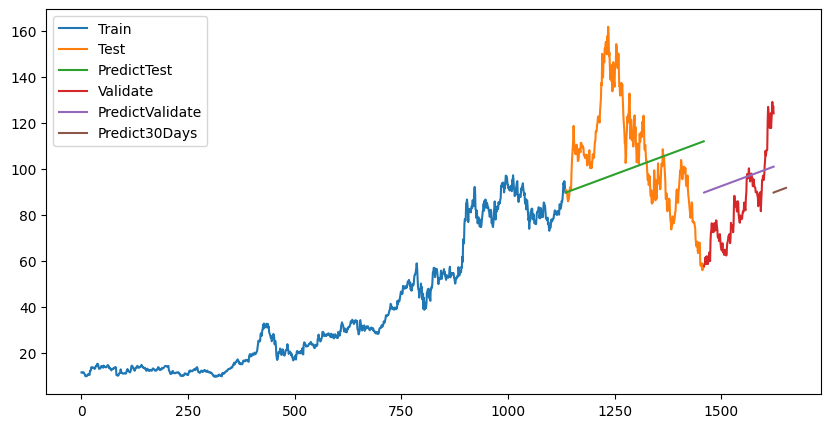

In [7]:
# 9.Vẽ hình
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_val)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'PredictTest','Validate','PredictValidate','Predict30Days'])
plt.show()

In [8]:
test_data.index

RangeIndex(start=1136, stop=1460, step=1)